In [1]:
import pandas as pd
import re
from simhash import Simhash, SimhashIndex
import seaborn as sns
import numpy as np
from sklearn import mixture
import scipy.stats as stats
import pickle
import os
from scipy.optimize import curve_fit
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from matplotlib import colors
def shift_value(rgb, shift):
    hsv = colors.rgb_to_hsv(rgb)
    hsv[-1] += shift
    return colors.hsv_to_rgb(hsv)
def color_palette(n_colors):
    orig_palette = sns.color_palette(n_colors=n_colors)
    shifts = np.linspace(-.3, .3, n_colors)
    alternate_shifts = shifts.copy()
    alternate_shifts[::2] = shifts[:len(shifts[::2])]
    alternate_shifts[1::2] = shifts[len(shifts[::2]):]
    palette = [shift_value(col, shift)
               for col, shift in zip(orig_palette, alternate_shifts)]
    return palette

# todo
- Try again with two instead of three
- playing with small f.prob_gold to signal mixed cases
- Try to use Bayesian Gaussian Mixture models

In [3]:
import seaborn as sns
def set_style():
    # This sets reasonable defaults for font size for
    # a figure that will go in a paper
    sns.set_context("paper")
    
    # Set the font to be serif, rather than sans
    sns.set(font='serif')
    
    # Make the background white, and specify the
    # specific font family
    sns.set_style("whitegrid", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
def set_size(fig,w=6,h=3):
    fig.set_size_inches(w, h)
    plt.tight_layout()
set_style()

In [11]:
df = pd.read_csv("./political/CSTA-APSR-master/Data - CF jobs/CFjobresults/f269506_html.csv",low_memory=False)

In [16]:
def simulator(df,test_quiz=True,steps=-1,gold_per_quiz=8,unit_per_page=10,gold_per_page=1,to_remove=0,verbose=0,gold_options=3):
    from IPython import display
    def sort_df(df):
        return df.sort_values(by='_started_at',ascending=True).reset_index(drop = True)
    
    def compute_min_ratio(non_golds,test_quiz):
        if test_quiz:
            return (gold_per_quiz+gold_per_page)/len(non_golds) #max one page 
        else:
            return 1/len(non_golds)
   
    def remove_first_page(df):
        def first_page_group(group):
            ll = list(group.groupby('_started_at'))
            if len(ll)>1:
                return pd.concat([x[1] for x in ll[1:]])
            else:
                return None
        return df.groupby('_worker_id').apply(first_page_group)
    
    def remove_some(group):
        if group.head(1)['_golden'].item() == False:
            return group.head(10-to_remove)
        else:
            return group    
    
    def clustering_old(data): #data should be np.array shape=(N,1)
        gmm = mixture.GaussianMixture(n_components=2,covariance_type='spherical',n_init=10,warm_start=True,means_init=[[1],[10],[20]])
        if data.size < 10:
            return (np.full(data.size,False),np.full(data.size,np.nan),np.array([np.nan]),gmm)
        gmm.fit(data)
        if gmm.converged_==False:
            print("error",gmm.means_)
        predict = gmm.predict(data)
        probs= gmm.predict_proba(data)
        gold = np.argmax(gmm.means_)
        non_gold = np.argmin(gmm.means_)
        if (gold != non_gold):
            probs = np.array([ t[gold] for t in probs])
        else:
            probs = np.full(predict.shape,np.nan)
            predict_gold = np.full(predict.shape,False)
            return (predict_gold,probs,np.array([np.nan]),gmm)
        predict_gold=np.full(predict.shape, False)
        predict_gold[predict==gold] = True
        threshold = find_intercept(gmm.means_[0][0],gmm.means_[1][0],gmm.covariances_[0],gmm.covariances_[1])
        if len(threshold) < 1:
            threshold = np.array([np.nan])
        return (predict_gold,probs,threshold[0],gmm)    
    
    def clustering(data): #data should be np.array shape=(N,1)
        #gmm = mixture.GaussianMixture(n_components=3,covariance_type='spherical',n_init=10,warm_start=True,means_init=[[1],[10],[20]])
        gmm = mixture.GaussianMixture(n_components=2,covariance_type='spherical')#,n_init=10,warm_start=True,means_init=[[1],[10],[20]])
        if data.size < 10:
            return (np.full(data.size,False),np.full(data.size,np.nan),np.array([np.nan]),gmm)
        gmm.fit(data)
        if gmm.converged_==False:
            print("error",gmm.means_)
        predict = gmm.predict(data)
        probs= gmm.predict_proba(data)
        gold = np.argsort(gmm.means_,axis=0)[-1][0]
        non_gold = np.argsort(gmm.means_,axis=0)[-2][0]
        if (gold != non_gold):
            probs = np.array([ t[gold] for t in probs])
        else:
            probs = np.full(predict.shape,np.nan)
            predict_gold = np.full(predict.shape,False)
#            print('|Problem'+str(gold)+'-'+str(non_gold)+'-'+str(gmm.means_)+"t:"+str([np.nan])+" |",end='')
            return (predict_gold,probs,np.array([np.nan]),gmm)
        predict_gold=np.full(predict.shape, False)
        predict_gold[predict==gold] = True
        predict_gold[predict!=gold] = predict[predict!=gold]
        threshold = find_intercept(gmm.means_[gold][0],gmm.means_[non_gold][0],gmm.covariances_[gold],gmm.covariances_[non_gold])
        if threshold[0]<= gmm.means_[gold][0] and threshold[0]>= gmm.means_[non_gold][0]:
            correct_threshold = threshold[0]
        elif threshold[1]<= gmm.means_[gold][0] and threshold[1]>= gmm.means_[non_gold][0]:
            correct_threshold = threshold[1]
        else:
            correct_threshold = gmm.means_[non_gold][0] + (gmm.means_[gold][0] - gmm.means_[non_gold][0]) /2
#        print(str('|')+str(gold)+'-'+str(non_gold)+'-'+str(gmm.means_)+"t:"+str(threshold)+" |",end='')
        if len(threshold) < 1:
            threshold = np.array([np.nan])
        return (predict_gold,probs,correct_threshold,gmm)    

    def clustering_log(data):
        def gauss_function(x, a, x0, sigma,b,x1,sigma1):
            return a*np.exp(-(x-x0)**2/(2*sigma**2)) + b*np.exp(-(x-x1)**2/(2*sigma1**2))
        histy,histx = np.histogram(data)
        histy = np.log(histy).clip(0,np.inf)
        popt, pcov = curve_fit(gauss_function, histx, histy, p0 = [1, 1, 0.1,0.5,10,10])
        threshold = find_intercept(popt[1],popt[4],popt[2],potp[5])
        goldvalue = np.max([popt[1],popt[4]])
        nongoldvalue = np.min([popt[1],popt[4]])
        if threshold[0]<= goldvalue and threshold[0]>= nongoldvalue:
            correct_threshold = threshold[0]
        elif threshold[1]<= goldvalue and threshold[0]>= nongoldvalue:
            correct_threshold = threshold[1]
        else:
            correct_threshold = nongoldvalue + (goldvalue - nongoldvalue) /2
        predict_gold = np.full(data.shape,False)
        predict_gold[data>threshold] = True
        probs = np.full(data.shape,0.5)
        return (predict_gold,probs,correct_threshold,None)
        
    
    def clustering_ok(data): #data should be np.array shape=(N,1)
        gmm = mixture.GaussianMixture(n_components=1,covariance_type='spherical')#,n_init=10,warm_start=True,means_init=[[10],[20]])
        if data.size < 10:
            return (np.full(data.size,False),np.full(data.size,np.nan),np.array([np.nan]),gmm)
        gmm.fit(data)
        data.shape=(-1,)
        value = np.max(gmm.means_)
        predict_gold = np.full(len(data),fill_value=False)
        probs = np.full(len(data),fill_value=0)
        predict_gold[np.where(data>value)] = True
        probs[np.where(data>value)] = 1
        return (predict_gold,probs,value,gmm)
    
    def find_intercept(m1,m2,var1,var2):
      a = 1/(2*var1) - 1/(2*var2)
      b = m2/(var2) - m1/(var1)
      c = m1**2 /(2*var1) - m2**2 / (2*var2) - np.log(var2/var1)/2
      return np.roots([a,b,c])
    
    def simulate_work(df):
        df['hash'] = df.html.apply(lambda x: Simhash(shingle(x)))
        df['multiplicity'] = 0
        grouped = df.groupby(['_started_at','_worker_id'],as_index=False,group_keys=False)
        for (time,worker),group in grouped:
            report_page(group)
            for row in group.itertuples(index=True):
                idx = row[0]
                df.loc[idx,'multiplicity'] = multiplicity[getattr(row,'hash').value]
            p_gold,p_prob,thresh = predict_page(group)
            df.loc[group.index,'prediction_gold'] = p_gold
            df.loc[group.index,'prob_gold'] = p_prob
            df.loc[group.index,'threshold'] = thresh
        return df

    def predict_page(df):
        nonlocal counter
        idx = np.array(list(multiplicity.keys()),dtype=uint64)
        data = np.array(list(multiplicity.values()),dtype=int)
        data.shape = (-1,1)
        idx.shape = (-1,1)
        (predict_gold,probs,threshold,gmm) = clustering(data)
        predictor = dict(zip(idx.flatten(),predict_gold))
        prob_predictor = dict(zip(idx.flatten(),probs))
        p_gold = df.hash.apply(lambda x: x.value).map(predictor)
        p_prob = df.hash.apply(lambda x: x.value).map(prob_predictor)
        if verbose>0 and (((counter-1) % 100) == 0):
            print(threshold,gmm.means_,gmm.covariances_,np.argsort(gmm.means_,axis=0)[-2][0],np.argsort(gmm.means_,axis=0)[-1][0])
        return p_gold,p_prob,threshold

    def report_page(df): #df is only a page
        nonlocal counter
        for h in df['hash']:
            if h.value in multiplicity:
                multiplicity[h.value] += 1
            else:
                multiplicity[h.value] = 1
        if verbose>0 and (counter % 100 == 0):
            plt.hist(list(multiplicity.values()))
            display.display(plt.gcf())
            plt.close()
        counter +=1

                
    def bit_difference(string1, string2):
        return Simhash(shingle(string1)).distance(Simhash(shingle(string2)))

    def shingle(tokens,length=3):
        return [tokens[i:i+length] for i in range(len(tokens) - length + 1) if len(tokens[i]) < 4]
    
    def worker_subset(df,golds,test_quiz=True): #golds are unique golds, df is worker group
        # call it like df.groupby('_worker_id',as_index=False,group_keys=False).apply(lambda x: worker_subset(x,golds ))
        df._created_at = pd.to_datetime(df._created_at)
        df = df.sort_values(by='_started_at',ascending=True).reset_index(drop = True)
        if test_quiz:
            assert len(golds)>gold_per_quiz, len(golds)
        n_gold_needed = len(df[df._golden==True])
        if len(golds) < n_gold_needed:
            df = df[((df._golden==True).cumsum()<=len(golds)) | (df._golden==False)]
            n_gold_needed = len(golds)
        gold_created = golds.sample(n=n_gold_needed,replace=False)
        df.loc[df._golden==True,~df.columns.isin(['_started_at','_created_at','_worker_id','_missed'])] \
              = gold_created.loc[:,~gold_created.columns.isin(['_started_at','_created_at','_worker_id','_missed'])].as_matrix()
        df._golden = df._golden.astype(bool) #fix case in which inferred type is wrong because no gold present
        return df

    def compute_accuracy(workgroup,what):
        ll = len(workgroup)
        golds_first = gold_per_quiz
        to_divide = np.insert(np.ones(ll-1),0,golds_first) #add an 8 at the beginning (number of golds)
        return (to_divide-workgroup[what]).cumsum()/to_divide.cumsum()
    
    def compute_page(df):
        def FP(row):
            tp=tn=fp=fn = 0
            if row['_golden']:
                if row['prediction_gold']:
                    tp = 1
                else:
                    fn = 1
            else:
                if row['prediction_gold']:
                    fp = 1
                else:
                    tn = 1
            return pd.Series([tp,tn,fp,fn])
        df[['tp','tn','fp','fn']]= df.apply(FP,axis=1)
        tp = df['tp'].sum(); tn = df['tn'].sum(); fp = df['fp'].sum(); fn = df['fn'].sum()
        time_spent=normal_time = df._created_at.iloc[0] -df._started_at.iloc[0]
        missed_orig = df['_missed'].sum()
        missed = missed_orig
        if df['_golden'].sum()<2: #not in first page
            if (tp>0 or fp>0): #if I get a signal I ignore the other questions
                time_spent = time_spent/10 * (fp+tp)
            if (fn==1):
                if (missed_orig==0): # if the signal was wrong and I was a good worker I become bad worker with probability
                    #missed = 1
                    missed = 0 if np.random.randint(0,gold_options)==0 else 1
        count = len(df)
        
        return pd.Series({"tp":tp,"tn": tn,"fp":fp,"fn":fn,"missed":missed, 'time_spent':time_spent,'count':count,'time_orig':normal_time,'missed_orig':missed_orig})

    # START HERE
    #clustering = clustering_log
    df._missed = df['_missed'].fillna(False)
    df._started_at = pd.to_datetime(df._started_at)
    df._created_at = pd.to_datetime(df._created_at)
    if to_remove > 0:
        df = df.groupby('_unit_id',group_keys=False,as_index=False).apply(remove_some)
    df = sort_df(df)
    if not test_quiz:
        print("Removing gold ",len(df))
        df = sort_df(remove_first_page(df))
        print("Removed ",len(df))
    golds = df[df._golden==True].groupby('_unit_id',as_index=False).first() #unique golds
    assert len(golds)>0, "Dataset is too small"
    non_golds = df[df._golden==False].groupby('_unit_id',as_index=False).first() #unique non-gold
    max_ratio = len(golds)/len(non_golds)
    min_ratio = compute_min_ratio(non_golds,test_quiz=test_quiz)
    if steps == -1:
        ratios = 1
    else:
        ratios = np.linspace(min_ratio,max_ratio,steps)
    results = []
    performances = []
    mults = []
    for r in ratios:
#        global multiplicity
        multiplicity = {}
        counter = 1
        g = max (1,np.ceil(len(non_golds) * r).astype(int))# number of golds used here
        print('Using '+str(g)+' golds('+str(100*r)+"%)")
        result = sort_df(df.groupby('_worker_id',as_index=False,group_keys=False).apply(lambda x: worker_subset(x,golds.head(g),test_quiz=test_quiz )))
        result = simulate_work(result)
        performance = sort_df(result.groupby(['_started_at','_worker_id']).apply(lambda group: compute_page(group)).reset_index())
        performance['time_cumsum_per_worker'] = performance.groupby('_worker_id',as_index=False,group_keys=False).apply(lambda group: cumsum(group['time_spent']))
        performance['count_cumsum'] = performance['count'].cumsum()
        performance['bin'] = pd.cut(performance['count_cumsum'],linspace(0,performance['count'].sum(),11),labels=[str((x+1)*10)+'%' for x in range(10)])
        performance['time_orig_s'] = performance['time_orig'].apply(lambda x: x.total_seconds())
        performance['time_spent_s'] = performance['time_spent'].apply(lambda x: x.total_seconds())
        performance['accuracy'] = performance.groupby(['_worker_id'],as_index=False,group_keys=False).apply(lambda x: compute_accuracy(x,'missed'))
        performance['accuracy_orig'] = performance.groupby(['_worker_id'],as_index=False,group_keys=False).apply(lambda x: compute_accuracy(x,'missed_orig'))
        performances.append(performance)
        results.append(result)
        mults.append(multiplicity)
    final = pd.concat(results, keys=range(len(ratios)))
    perf_df = pd.concat(performances, keys=range(len(ratios)))
    mult_df = pd.DataFrame.from_records(mults,index=range(len(ratios)))
    ratios_s = pd.Series(ratios)
    return (final,mult_df,ratios_s,perf_df)

In [4]:
def load_result(test=True,steps=10,to_remove=0):
    filename= '2-'+str(to_remove)+'-'+str(steps)+"-"+str(test)+'-'
    df_name = filename+'df'
    mult_name = filename+'mult'
    ratios_name = filename+'ratios'
    perf_name = filename+'perf'
    f = pd.read_pickle(df_name+'.pkl')
    m = pd.read_pickle(mult_name+'.pkl')
    r = pd.read_pickle(ratios_name+'.pkl')
    p = pd.read_pickle(perf_name+'.pkl')
    return f,m,r,p

In [18]:
for to_remove in [6,0]:#[4,2,0]:
    for test in [True,False]:
        steps = 4
        filename= '2-'+str(to_remove)+'-'+str(steps)+"-"+str(test)+'-'
        df_name = filename+'df'+'.pkl'
        mult_name = filename+'mult'+'.pkl'
        ratios_name = filename+'ratios'+'.pkl'
        perf_name = filename+'perf'+'.pkl'
        if not os.path.exists(df_name):
            f,m,r,p = simulator(df,test_quiz=test,steps=steps,to_remove=to_remove,verbose=0)
            f.to_pickle(df_name)
            m.to_pickle(mult_name)
            r.to_pickle(ratios_name)
            p.to_pickle(perf_name)
        else:
            print("Already exist!")

Using 9 golds(0.3757828810020877%)
Using 106 golds(4.398051496172582%)
Using 202 golds(8.420320111343075%)
Using 298 golds(12.44258872651357%)
Removing gold  14900
Removed  12088
Using 1 golds(0.04175365344467641%)
Using 100 golds(4.175365344467641%)
Using 199 golds(8.308977035490607%)
Using 298 golds(12.44258872651357%)


In [5]:
flatui = ['#8dd3c7','#bebada']
sns.set_palette(flatui)

In [6]:
def plot_perf_time(performance):
    melted_performance_time = pd.melt(performance[['time_spent_s', 'time_orig_s', 'bin']].rename(columns={'bin':'Total work progress' ,'time_spent_s':'simhash','time_orig_s':'original'}),value_name='Time [s]' ,var_name=['Technique'],id_vars=['Total work progress'])
    sns.pointplot(data=melted_performance_time,x='Total work progress',y='Time [s]',hue='Technique',capsize=0.2,linestyles=['--','-'])
    plt.ylabel('Average time per page [s]')
    plt.ylim([50,350])

In [7]:
def plot_perf_missed(performance):
    workers_per_bin = performance.groupby('bin').apply(lambda group: len(group._worker_id.unique()))
    performance['missed'] = performance.apply(lambda x: x.missed/workers_per_bin[x.bin] ,axis=1)
    performance['missed_orig'] = performance.apply(lambda x: x.missed_orig/workers_per_bin[x.bin] ,axis=1)
    melted_performance_missed = pd.melt(performance[['bin', 'missed','missed_orig']].rename(columns={'bin':'Total work progress' ,'missed':'simhash','missed_orig':'original'}),value_name='Number of gold missed' ,var_name=['Technique'],id_vars=['Total work progress'])
    sns.pointplot(data=melted_performance_missed,x='Total work progress',y='Number of gold missed',hue='Technique',capsize=0.2,estimator=sum,linestyles=['--','-'])
    plt.ylabel('Average gold missed per worker')

In [8]:
def plot_perf_accuracy(performance):
    workers_per_bin = performance.groupby('bin').apply(lambda group: len(group._worker_id.unique()))
    melted_performance_missed = pd.melt(performance[['bin', 'accuracy','accuracy_orig']].rename(columns={'bin':'Total work progress' ,'accuracy':'simhash','accuracy_orig':'original'}),value_name='Accuracy' ,var_name=['Technique'],id_vars=['Total work progress'])
    sns.pointplot(data=melted_performance_missed,x='Total work progress',y='Accuracy',hue='Technique',capsize=0.2,estimator=mean,linestyles=['--','-'])
    plt.ylabel('Average accuracy')
    plt.ylim([0.7,1])

Note that changing the following threshold can help a lot!

In [13]:
f[(f.prob_gold>0.4) & (f._golden==True)].count()

_unit_id           13114
_started_at        13114
_created_at        13114
_golden            13114
_worker_id         13114
_missed            13114
sentence_text      13114
pre_sentence       13114
post_sentence      13114
html               13114
hash               13114
multiplicity       13114
prediction_gold    13114
prob_gold          13114
threshold          13114
dtype: int64

In [14]:
f[(f.prob_gold<0.1) & (f.prediction_gold == False) & (f._golden==True)].count() #playing with small f.prob_gold to signal mixed cases

_unit_id           1055
_started_at        1055
_created_at        1055
_golden            1055
_worker_id         1055
_missed            1055
sentence_text      1055
pre_sentence       1055
post_sentence      1055
html               1055
hash               1055
multiplicity       1055
prediction_gold    1055
prob_gold          1055
threshold          1055
dtype: int64

In [9]:
steps = 4
for test in [True,False]:
    for to_remove in [6,0]:#,4,2,0]:
        f,m,r,p = load_result(test=test,steps=steps,to_remove=to_remove)
        for i in range(steps):
            plot_perf_missed(p.loc[i])
            plt.title("Gold ratio: "+str(round(100*r.loc[i],2))+"%, "+str(10-to_remove)+' judgements per non-gold')
            set_size(plt.gcf(),w=6,h=4)
            plt.savefig('2-'+str(to_remove)+'-'+str(test)+'-missed-'+str(i)+'.pdf')
            plt.close()
            plot_perf_time(p.loc[i])
            plt.title("Gold ratio: "+str(round(100*r.loc[i],2))+"%, "+str(10-to_remove)+' judgements per non-gold')
            set_size(plt.gcf(),w=6,h=4)
            plt.savefig('2-'+str(to_remove)+'-'+str(test)+'-time-'+str(i)+'.pdf')
            plt.close()
            plot_perf_accuracy(p.loc[i])
            plt.title("Gold ratio: "+str(round(100*r.loc[i],2))+"%, "+str(10-to_remove)+' judgements per non-gold')
            set_size(plt.gcf(),w=6,h=4)
            plt.savefig('2-'+str(to_remove)+'-'+str(test)+'-acc-'+str(i)+'.pdf')
            plt.close()

/home/eddy/.virtualenvs/pandas/lib/python3.4/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/eddy/.virtualenvs/pandas/lib/python3.4/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


(0, 50)

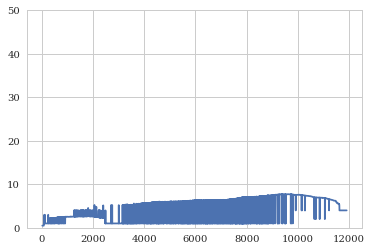

In [20]:
f.loc[1].threshold[10:].plot()
plt.ylim([0,50])

In [363]:
temp = f.loc[1]
temp[(temp.threshold>15) & (temp._golden==True)]

,_unit_id,_started_at,_created_at,_golden,_worker_id,_missed,sentence_text,pre_sentence,post_sentence,html,hash,multiplicity,prediction_gold,prob_gold,threshold
1695,334667708,2013-10-23 18:07:54,2013-10-23 18:09:28,True,17994920,False,"If just 5 more people in every 700 support us,...","At the last election, the Alliance won nearly ...",Think of it. Issues would be judged on their m...,"<div class=""cml jsawesome"" id=""{}""><p>At the l...",<simhash.Simhash object at 0x11f36f320>,9,False,0.000000e+00,15.007643
1706,334667696,2013-10-23 18:08:32,2013-10-23 18:13:59,True,11920016,False,But it's not difficult to understand why so ma...,"At the last election, about a third of the nat...",Since the last war the Tories and Labour have ...,"<div class=""cml jsawesome"" id=""{}""><p>At the l...",<simhash.Simhash object at 0x11f36fbe0>,6,False,0.000000e+00,15.007631
1717,334667615,2013-10-23 18:08:45,2013-10-23 18:09:31,True,20949410,False,It seems in retrospect to be the history of an...,"That a minority Labour Government, staggering ...",Yet these things happened and people had to ac...,"<div class=""cml jsawesome"" id=""{}""><p>That a m...",<simhash.Simhash object at 0x11e05dc88>,6,False,0.000000e+00,15.006565
1718,334667644,2013-10-23 18:08:53,2013-10-23 18:15:13,True,21326764,False,Northern Ireland. The British people have show...,In particular we have enfranchised British cit...,We resolutely support the security forces in t...,"<div class=""cml jsawesome"" id=""{}""><p>In parti...",<simhash.Simhash object at 0x11e05d828>,11,False,0.000000e+00,15.007494
1719,334667650,2013-10-23 18:08:53,2013-10-23 18:15:13,True,21326764,False,A Better Society. Planning and the Environment...,Great cities are built on the enterprise and v...,We are determined to maintain our national her...,"<div class=""cml jsawesome"" id=""{}""><p>Great ci...",<simhash.Simhash object at 0x11e05d2b0>,9,False,0.000000e+00,15.007494
1720,334667713,2013-10-23 18:08:53,2013-10-23 18:15:13,True,21326764,False,MATERNITY GRANT. We will introduce a maternity...,The net cost will be &lt;U+00A3&gt;268 million...,FAMILIES IN WORK. We will add &lt;U+00A3&gt;5 ...,"<div class=""cml jsawesome"" id=""{}""><p>The net ...",<simhash.Simhash object at 0x11e05d128>,5,False,0.000000e+00,15.007494
1721,334667716,2013-10-23 18:08:53,2013-10-23 18:15:13,True,21326764,False,Thanks to our success in controlling public sp...,That means we can reduce the amount government...,This is one of the reasons why we are becoming...,"<div class=""cml jsawesome"" id=""{}""><p>That mea...",<simhash.Simhash object at 0x11e05d470>,7,False,0.000000e+00,15.007494
1722,334667697,2013-10-23 18:08:53,2013-10-23 18:15:13,True,21326764,False,Since the last war the Tories and Labour have ...,It's hard to think of a more damning condemnat...,Many honourable men and women on both sides ha...,"<div class=""cml jsawesome"" id=""{}""><p>It's har...",<simhash.Simhash object at 0x11e05d048>,9,False,0.000000e+00,15.007494
1723,334667684,2013-10-23 18:08:53,2013-10-23 18:15:13,True,21326764,False,And eventually for there can be no trifling wi...,It has been torn up by our opponents. Labour's...,The Liberals and Social Democrats would take u...,"<div class=""cml jsawesome"" id=""{}""><p>It has b...",<simhash.Simhash object at 0x11e05db38>,6,False,0.000000e+00,15.007494
1724,334667670,2013-10-23 18:08:53,2013-10-23 18:15:13,True,21326764,False,We have made numerous proposals to that end.,We stood up to aggression in the Falklands and...,But we stand by our pledges to the Islanders. ...,"<div class=""cml jsawesome"" id=""{}""><p>We stood...",<simhash.Simhash object at 0x11e05dd68>,5,False,0.000000e+00,15.007494


In [39]:
    def clustering(data): #data should be np.array shape=(N,1)
        gmm = mixture.GaussianMixture(n_components=2,covariance_type='spherical',n_init=100,warm_start=True)
        if data.size < 10:
            return (np.full(data.size,False),np.full(data.size,np.nan),np.array([np.nan]),gmm)
        gmm.fit(data)
        predict = gmm.predict(data)
        probs= gmm.predict_proba(data)
        gold = np.argmax(gmm.means_)
        non_gold = np.argmin(gmm.means_)
        if (gold != non_gold):
            probs = np.array([ t[gold] for t in probs])
        else:
            probs = np.full(predict.shape,np.nan)
            predict_gold = np.full(predict.shape,False)
            return (predict_gold,probs,np.array([np.nan]),gmm)
        predict_gold=np.full(predict.shape, False)
        predict_gold[predict==gold] = True
        threshold = find_intercept(gmm.means_[0][0],gmm.means_[1][0],gmm.covariances_[0],gmm.covariances_[1])
        if len(threshold) < 1:
            threshold = np.array([np.nan])
        return (predict_gold,probs,threshold[0],gmm)
    
    def find_intercept(m1,m2,var1,var2):
      a = 1/(2*var1) - 1/(2*var2)
      b = m2/(var2) - m1/(var1)
      c = m1**2 /(2*var1) - m2**2 / (2*var2) - np.log(var2/var1)/2
      return np.roots([a,b,c])

In [57]:
gmm = mixture.GaussianMixture(n_components=2,covariance_type='spherical',n_init=100)
gmm.fit(m.loc[2].as_matrix().reshape(-1, 1))

GaussianMixture(covariance_type='spherical', init_params='kmeans',
        max_iter=100, means_init=None, n_components=2, n_init=100,
        precisions_init=None, random_state=None, reg_covar=1e-06,
        tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
        weights_init=None)

In [58]:
predict = gmm.predict(m.loc[2].as_matrix().reshape(-1, 1))

In [59]:
gmm.means_

array([[10.        ],
       [15.14940431]])

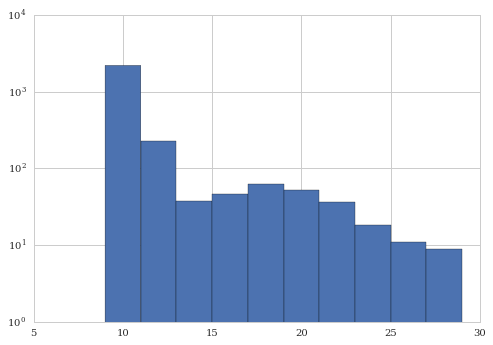

In [45]:
threshold = find_intercept(gmm.means_[0][0],gmm.means_[1][0],gmm.covariances_[0],gmm.covariances_[1])
threshold

array([10.00425762,  9.99574188])

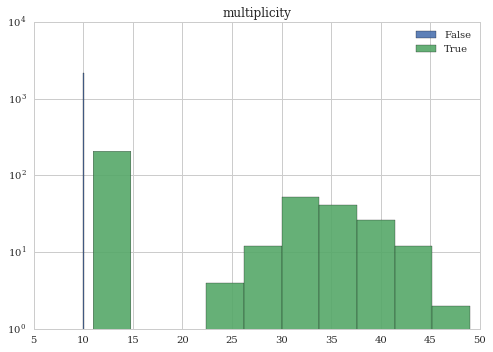

In [808]:
fig, axs = plt.subplots(ncols=1)
df.groupby('pred').hist(alpha=0.9,ax=axs,log=True)
plt.legend(['False','True'])

In [771]:
df = pd.DataFrame(mults[1],index=[0]).T
df.loc[np.array(list(mults[1].keys()),dtype=uint64),'pred'] = clustering(np.array(list(mults[1].values())).reshape(-1,1))[0]
df.rename(columns={0: 'multiplicity'}, inplace=True)
df.head()

,multiplicity,pred
3461897585987069,10,False
21749514495252249,10,False
43150513244264091,10,False
56309847637410143,10,False
75718564276238331,10,False


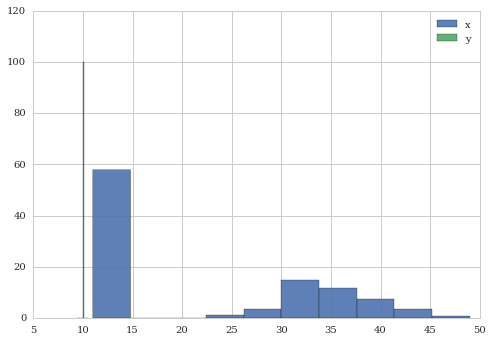

In [803]:
x = df[df.pred==True].multiplicity.as_matrix()
y = df[df.pred==False].multiplicity.as_matrix()
xweights = 100 * np.ones_like(x) / x.size
yweights = 100 * np.ones_like(y) / y.size

pyplot.hist(x, weights=xweights, alpha=0.9, label='x')
pyplot.hist(y, weights=yweights, alpha=0.9, label='y')
pyplot.legend(loc='upper right')

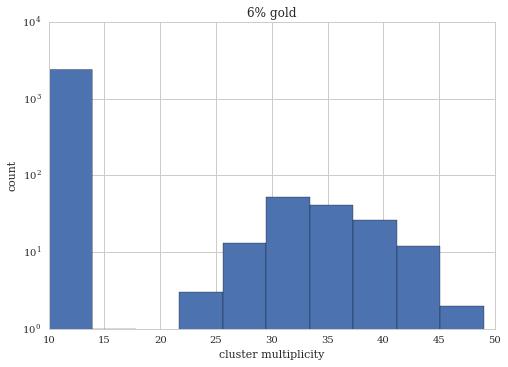

In [748]:
plt.hist(np.array(list(mults[1].values())),log=True);
plt.xlabel('cluster multiplicity')
plt.ylabel('count')
plt.title('6% gold')

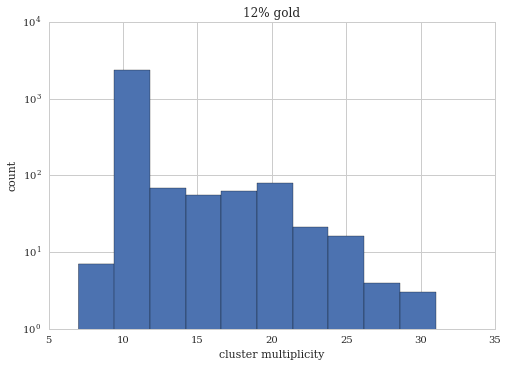

In [749]:
plt.hist(np.array(list(mults[2].values())),log=True);
plt.xlabel('cluster multiplicity')
plt.ylabel('count')
plt.title('12% gold')

# Simulation analysis

In [405]:
#result = pd.read_pickle("result.pkl")

In [ ]:
percentages = 

In [837]:
df = result.loc[4]
df._missed = df['_missed'].fillna(False)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [838]:
df.columns

Index(['_unit_id', '_started_at', '_created_at', '_golden', '_worker_id',
       '_missed', 'sentence_text', 'pre_sentence', 'post_sentence', 'html',
       'hash', 'multiplicity', 'prediction_gold', 'prob_gold'],
      dtype='object')

In [839]:
normal_time = (df['_created_at']-df['_started_at']).median()
quick_time = normal_time/10

In [840]:
a = pd.DataFrame([[1,2,3],[2,3,4]])
def test(df):
    return pd.Series([df.mean(),df.max()])
a[['c','d']]=a.apply(test,axis=1)

In [841]:
def compute_page(df,quick_time,normal_time):
    def FP(row):
        tp=tn=fp=fn = 0
        if row['_golden']:
            if row['prediction_gold']:
                tp = 1
            else:
                fn = 1
        else:
            if row['prediction_gold']:
                fp = 1
            else:
                tn = 1
        return pd.Series([tp,tn,fp,fn])
    df[['tp','tn','fp','fn']]= df.apply(FP,axis=1)
    tp = df['tp'].sum(); tn = df['tn'].sum(); fp = df['fp'].sum(); fn = df['fn'].sum()
    time_spent = normal_time
    missed_orig = df['_missed'].sum()
    missed = missed_orig
    if df['_golden'].sum()<2: #not in first page
        if (tp==1 or fp==1): #if I get a signal I ignore the other questions
            time_spent = quick_time
        if (fn==1):
            if (missed_orig==0): # if the signal was wrong and I was a good worker I become bad worker
                missed = 1
    count = len(df)
    return pd.Series({"tp":tp,"tn": tn,"fp":fp,"fn":fn,"missed":missed, 'time_spent':time_spent,'count':count,'time_orig':normal_time,'missed_orig':missed_orig})

In [842]:
piece = list(list(df.groupby('_worker_id'))[0][1].groupby('_started_at'))[0][1]
piece.head()

,_unit_id,_started_at,_created_at,_golden,_worker_id,_missed,sentence_text,pre_sentence,post_sentence,html,hash,multiplicity,prediction_gold,prob_gold
22218,334667844,2013-10-24 04:22:22,2013-10-24 04:25:29,True,1954947,False,but many of these offenders are more appropria...,Police cautions and intermediate treatment sho...,The probation service must be expanded to enab...,"<div class=""cml jsawesome"" id=""{}""><p>Police c...",<simhash.Simhash object at 0x1413d00f0>,14,False,9.324063e-22
22219,334667738,2013-10-24 04:22:22,2013-10-24 04:25:29,True,1954947,False,We must attract new private investment into re...,More must now be done. The next Conservative G...,"To do this we intend, in particular, to build ...","<div class=""cml jsawesome"" id=""{}""><p>More mus...",<simhash.Simhash object at 0x1413d0518>,13,False,2.620707e-12
22220,334667764,2013-10-24 04:22:22,2013-10-24 04:25:29,True,1954947,True,Socialist Spain as well as Christian Democrati...,This will provide substantial foreign earnings...,What we began in 1979 is today common internat...,"<div class=""cml jsawesome"" id=""{}""><p>This wil...",<simhash.Simhash object at 0x1413d5898>,17,False,1.514009e-65
22221,334667885,2013-10-24 04:22:22,2013-10-24 04:25:29,True,1954947,False,We will expand access to mother-tongue teachin...,Ensure equal opportunities for all. We will re...,Free immigration laws from racial discriminati...,"<div class=""cml jsawesome"" id=""{}""><p>Ensure e...",<simhash.Simhash object at 0x1413c16d8>,12,False,1.965096e-05
22222,334667636,2013-10-24 04:22:22,2013-10-24 04:25:29,True,1954947,True,a government without a good overall majority i...,All these improvements in the wealth and stand...,and a strong government with unso1ind policies...,"<div class=""cml jsawesome"" id=""{}""><p>All thes...",<simhash.Simhash object at 0x1413d3ba8>,20,False,1.683048e-132


In [843]:
performance = sort_df(df.groupby(['_started_at','_worker_id']).apply(lambda group: compute_page(group,quick_time,normal_time)).reset_index())

In [844]:
performance['time_cumsum_per_worker'] = performance.groupby('_worker_id',as_index=False,group_keys=False).apply(lambda group: cumsum(group['time_spent']))
performance['count_cumsum'] = performance['count'].cumsum()

In [845]:
performance.head()

,_started_at,_worker_id,count,fn,fp,missed,missed_orig,time_orig,time_spent,tn,tp,time_cumsum_per_worker,count_cumsum
0,2013-10-23 16:57:19,21273396,10,8,0,2,2,00:02:51,00:02:51,2,0,00:02:51,10
1,2013-10-23 16:57:20,19638651,10,8,0,1,1,00:02:51,00:02:51,2,0,00:02:51,20
2,2013-10-23 16:58:59,21223910,10,7,0,1,1,00:02:51,00:02:51,2,1,00:02:51,30
3,2013-10-23 17:00:48,21309857,10,8,0,2,2,00:02:51,00:02:51,2,0,00:02:51,40
4,2013-10-23 17:00:56,21258620,10,8,0,3,3,00:02:51,00:02:51,2,0,00:02:51,50


In [846]:
performance['count'].sum()

29505

In [847]:
linspace(0,performance['count'].sum(),10)

array([     0.        ,   3278.33333333,   6556.66666667,   9835.        ,
        13113.33333333,  16391.66666667,  19670.        ,  22948.33333333,
        26226.66666667,  29505.        ])

In [848]:
performance['bin'] = pd.cut(performance['count_cumsum'],linspace(0,performance['count'].sum(),11),labels=[str((x+1)*10)+'%' for x in range(10)])
performance['time_orig_s'] = performance['time_orig'].apply(lambda x: x.total_seconds())
performance['time_spent_s'] = performance['time_spent'].apply(lambda x: x.total_seconds())

In [849]:
performance.bin.unique()

[10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%]
Categories (10, object): [10% < 20% < 30% < 40% ... 70% < 80% < 90% < 100%]

In [850]:
performance.groupby('bin')['missed'].sum(),performance.groupby('bin')['missed_orig'].sum()

(bin
 10%     312
 20%     244
 30%     194
 40%     149
 50%     105
 60%     113
 70%     132
 80%     243
 90%     305
 100%    137
 Name: missed, dtype: int64, bin
 10%     209
 20%     111
 30%     103
 40%      90
 50%     105
 60%     113
 70%     132
 80%     128
 90%     124
 100%    136
 Name: missed_orig, dtype: int64)

In [851]:
performance.columns

Index(['_started_at', '_worker_id', 'count', 'fn', 'fp', 'missed',
       'missed_orig', 'time_orig', 'time_spent', 'tn', 'tp',
       'time_cumsum_per_worker', 'count_cumsum', 'bin', 'time_orig_s',
       'time_spent_s'],
      dtype='object')

In [852]:
melted_performance_time = pd.melt(performance[['bin', 'time_orig_s','time_spent_s']].rename(columns={'bin':'Total work progress' ,'time_spent_s':'simhash','time_orig_s':'original'}),value_name='Time [s]' ,var_name=['Technique'],id_vars=['Total work progress'])
melted_performance_missed = pd.melt(performance[['bin', 'missed','missed_orig']].rename(columns={'bin':'Total work progress' ,'missed':'simhash','missed_orig':'original'}),value_name='Number of gold missed' ,var_name=['Technique'],id_vars=['Total work progress'])

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


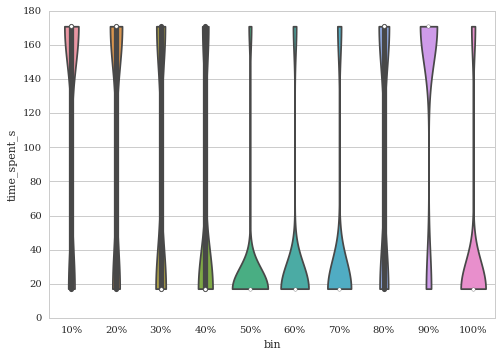

In [853]:
sns.violinplot(data=performance,x='bin',y='time_spent_s',cut=0)

In [854]:
melted_performance_missed = pd.melt(performance[['bin', 'missed','missed_orig']].rename(columns={'bin':'Total work progress' ,'missed':'simhash','missed_orig':'original'}),value_name='Number of gold missed' ,var_name=['Technique'],id_vars=['Total work progress'])
melted_performance_time = pd.melt(performance[['time_spent_s', 'time_orig_s', 'bin']].rename(columns={'bin':'Total work progress' ,'time_spent_s':'simhash','time_orig_s':'original'}),value_name='Time [s]' ,var_name=['Technique'],id_vars=['Total work progress'])

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/seaborn/categorical.py:637: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data[hue_mask])


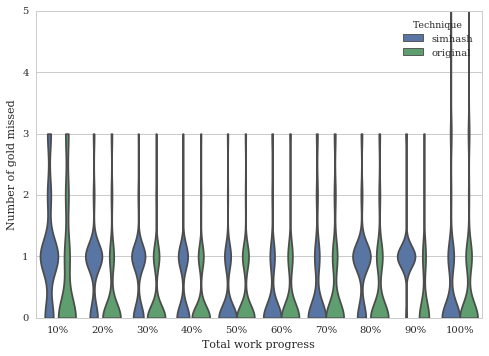

In [855]:
sns.violinplot(data=melted_performance_missed,x='Total work progress',y='Number of gold missed',hue='Technique',cut=0,inner=None);

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/seaborn/categorical.py:637: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data[hue_mask])


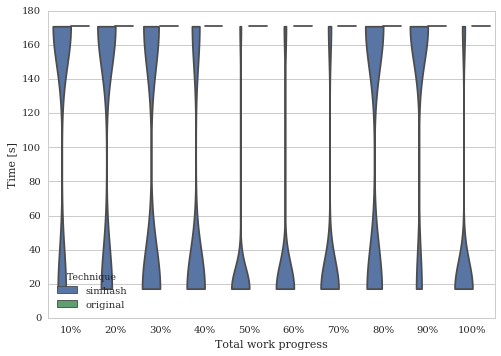

In [856]:
sns.violinplot(data=melted_performance_time,x='Total work progress',y='Time [s]',hue='Technique',cut=0,inner=None);

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


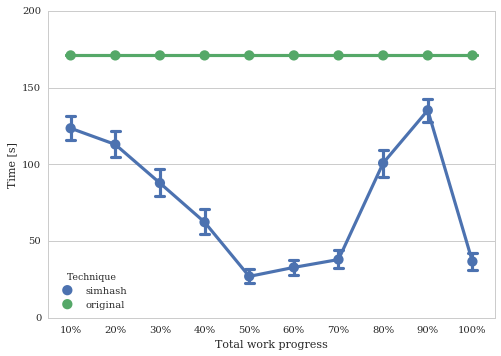

In [857]:
sns.pointplot(data=melted_performance_time,x='Total work progress',y='Time [s]',hue='Technique',capsize=0.2,)
plt.ylabel('Time [s]')

In [58]:
sns.pointplot(data=melted_performance_missed,x='Total work progress',y='Number of gold missed',hue='Technique',capsize=0.2,)
plt.ylabel('Empirical probability of missing a gold question')

NameError: name 'melted_performance_missed' is not defined

In [639]:
a = np.random.normal(loc=1,scale=1,size=(N,1))
b = np.random.normal(loc=10,scale=1,size=(N,1))

In [640]:
data = np.concatenate([a,b])

In [641]:
data.shape

(2, 1)